ECS 289L SQ23 - Abdel Ibrahim

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fracture-multi-region-x-ray-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4854718%2F8201044%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T020458Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5bedb43d76765416a1686b30bf12947b30cab2f2e460805c2d9b9f6eb1d395694d78f7cb813bca8e0f4ca5d337f8dd560368fccc81cfbc238e3bebce84dadb95c52060120658d7eb085240276be90ce00d7ea7a6109701c25650a9e6b0c5ef9532a975d66abb50952bcfe65683d1b0242e1fc189f71689d1d3955206fefee04959492e9e0c7849f060a449ffd7ed7ded8c54b5b47ada886bf586e7f0e39fd73b9c177d05fb737ba3926c5b887ed0f7738489b58d773a48c78bd65cb6be9b16633e386c36bc718b3e8b013aec3dbe48ad658d74034561f6883fbc03bb3460619fb78c8794b12e97ea232668e0e11288dedc4aed8b6751cdea261d8f74b1e0dd81'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 504652653 bytes downloaded
Downloaded and uncompressed: fracture-multi-region-x-ray-data
Data source import complete.


In [ ]:
!pip install tensorflow --upgrade
!pip install keras --upgrade

In [ ]:
import os
import numpy as np
from PIL import Image
import keras

dataset = keras.utils.image_dataset_from_directory('/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured', label_mode=None, image_size=(64, 64), batch_size = 32)
dataset = dataset.map(lambda x: x / 255.0)


Found 4606 files.


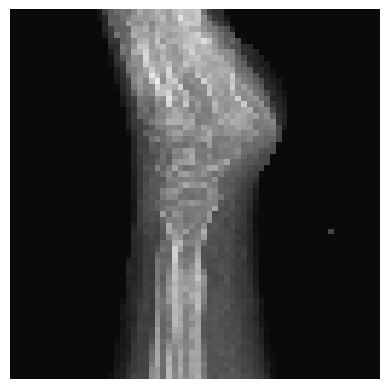

In [ ]:
from matplotlib import pyplot as plt
from google.colab import files

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


https://keras.io/examples/generative/dcgan_overriding_train_step/

In [ ]:
import keras
import tensorflow as tf

from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 8192)                │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 3)           │          38,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=5000, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        print(epoch)
        if epoch + 1 == 100:
            random_latent_vectors = keras.random.normal(
                shape=(self.num_img, self.latent_dim), seed=self.seed_generator
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            for i in range(self.num_img):
                img = keras.utils.array_to_img(generated_images[i])
                img_path = f"generated_images/generated_img_{epoch + 1:03d}_{i}.png"
                img.save(img_path)
                files.download(img_path)

In [ ]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5000, latent_dim=latent_dim)]
)

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 407ms/step - d_loss: 0.4418 - g_loss: 1.7273
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 267ms/step - d_loss: 0.2605 - g_loss: 3.3748
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - d_loss: 0.4865 - g_loss: 2.2429
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - d_loss: 0.5148 - g_loss: 2.7613
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - d_loss: 0.4368 - g_loss: 1.6631
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - d_loss: 0.6286 - g_loss: 1.8023
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - d_loss: 0.6088 - g_loss: 2.7421
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - d_loss: 0.7272 - g_loss: 1.1666
Epoch 9/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - d_loss: 0.6017 - g_loss: 1.0131
Epoch 10/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - d_loss: 0.5736 - g_loss: 1.3012
Epoch 11/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - d_loss: 0.6038 - g_loss: 1.3581
Epoch 1

ResourceExhaustedError: Exception encountered when calling Conv2DTranspose.call().

[1m{{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[5000,64,64,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput][0m

Arguments received by Conv2DTranspose.call():
  • inputs=tf.Tensor(shape=(5000, 32, 32, 256), dtype=float32)

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


drive_path = '/content/drive/MyDrive/GAN_models'
os.makedirs(drive_path, exist_ok=True)

generator_path = os.path.join(drive_path, 'generator_model.h5')
discriminator_path = os.path.join(drive_path, 'discriminator_model.h5')
gan.generator.save(generator_path)
gan.discriminator.save(discriminator_path)

print(f"Models saved to {drive_path}")

Mounted at /content/drive


Models saved to /content/drive/MyDrive/GAN_models


In [ ]:
# !pip install tensorflow --upgrade
# !pip install keras --upgrade
import os
import numpy as np
from tensorflow import keras
from google.colab import drive
import matplotlib.pyplot as plt
import random
import string

# Mount Google Drive
# drive.mount('/content/drive')

# Define the path where the models are saved in Google Drive
drive_path = '/content/drive/MyDrive/GAN_models'
generator_path = os.path.join(drive_path, 'generator_model.h5')

# Load the generator model
generator = keras.models.load_model(generator_path)

# Generate 50 images
latent_dim = 128  # Ensure this matches the latent_dim used during training
num_img_to_generate = 500

for j in range(20):
    seed_generator = keras.random.SeedGenerator(42)

    random_latent_vectors = keras.random.normal(
        shape=(num_img_to_generate, latent_dim), seed=seed_generator
    )
    generated_images = generator(random_latent_vectors)
    generated_images *= 255
    generated_images = generated_images.numpy()

    # Create a directory to save generated images
    generated_images_path = os.path.join(drive_path, 'generated_images')
    os.makedirs(generated_images_path, exist_ok=True)

    def generate_random_string(length=10):
        characters = string.ascii_letters + string.digits
        return ''.join(random.choice(characters) for i in range(length))

    # Save the generated images and display them

    for i in range(num_img_to_generate):
        random_string = generate_random_string()
        img = keras.utils.array_to_img(generated_images[i])
        img_path = os.path.join(generated_images_path, f"fractured-{random_string}.png")
        img.save(img_path)



print(f"Generated images saved to {generated_images_path}")


Generated images saved to /content/drive/MyDrive/GAN_models/generated_images
